pytorch alexnet_transfer_learning no_synthetic_data no_normalization finetunning

# Transfer Learning for OxfordIIITPet Data using AlexNet

**Author**: [zoraiz](https://github.com/ramayzoraiz)


-   **Finetuning the ConvNet**: Instead of random initialization, we
    initialize the network with a pretrained network, like the one that
    is trained on imagenet 1000 dataset. Rest of the training looks as
    usual.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import numpy as np
from torchvision import models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import time
from PIL import Image
from torchinfo import summary
from pytorch_utils import load_data

# Set random seed for reproducibility
torch.manual_seed(42)
cudnn.benchmark = True
# cudnn.deterministic = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Hyperparameters

In [2]:
BATCH_SIZE = 256
IMAGE_SIZE = 128

## Load Data

In [3]:
train_ds, val_ds = load_data(IMAGE_SIZE)

In [4]:
class_names = train_ds.datasets[0].classes
NUM_CLASSES = len(class_names)
print(f"Number of classes: {NUM_CLASSES}")
print(f"Number of training samples: {len(train_ds)}")
print(f"Number of validation samples: {len(val_ds)}")

Number of classes: 37
Number of training samples: 6248
Number of validation samples: 1101


In [5]:
dataset_sizes = {'train': len(train_ds), 'val': len(val_ds)}
# Create data loaders
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True, prefetch_factor=2)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True, prefetch_factor=2)
dataloaders = {'train': train_loader, 'val': val_loader}

## dataloader samples visualization

In [6]:
batch, classes = next(iter(dataloaders['train']))

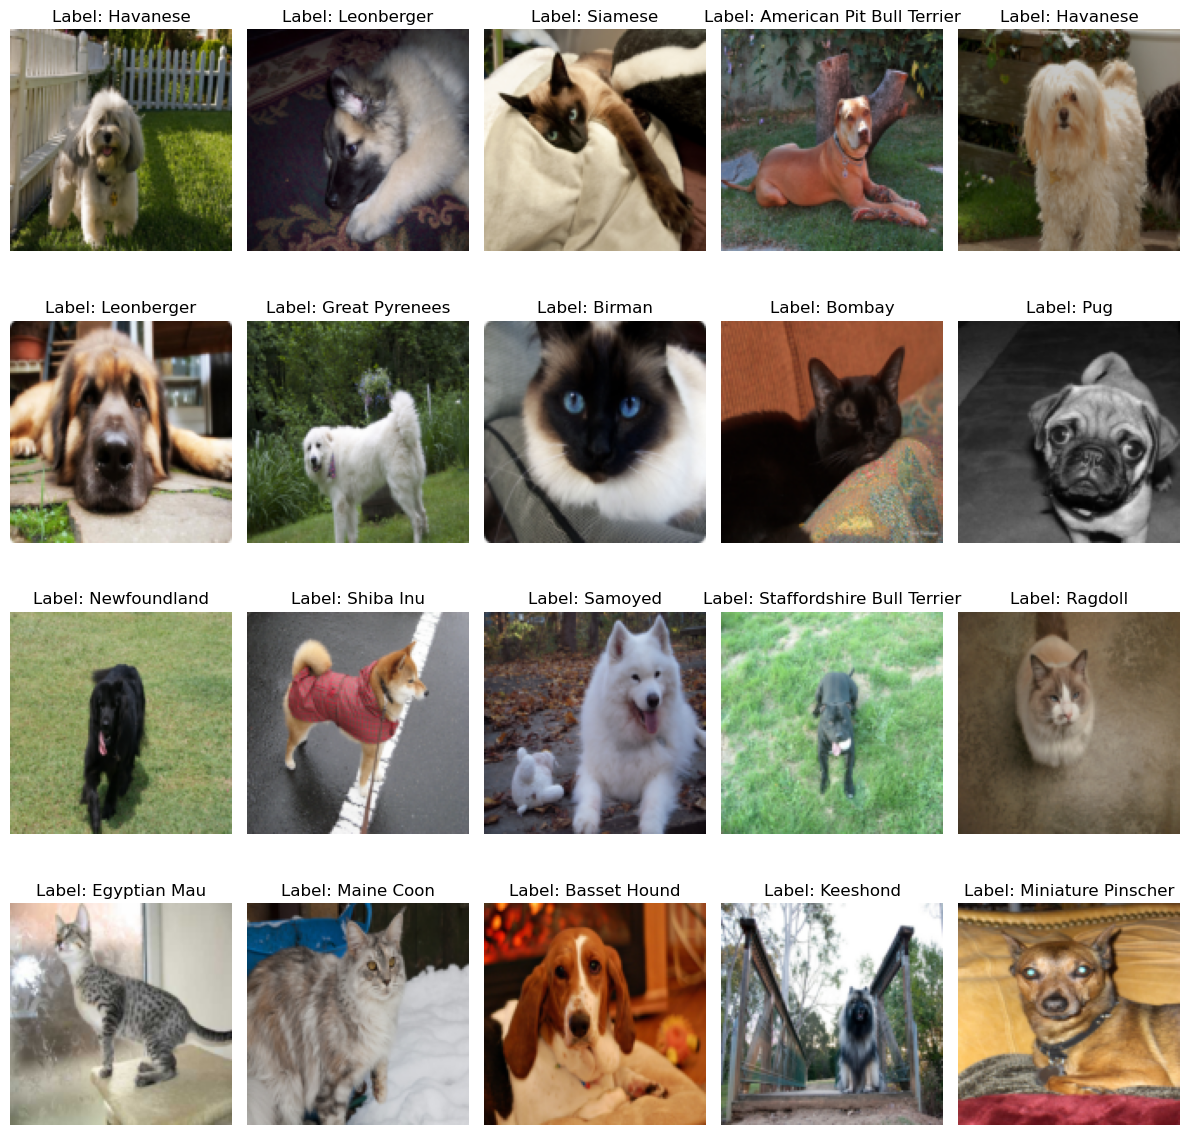

In [7]:
# Visualize 10 images from batch
fig, axs = plt.subplots(4, 5, figsize=(12, 12))
for i in range(20):
    image = batch[i]
    label = classes[i]
    image = image.numpy().transpose((1, 2, 0))
    axs[i // 5, i % 5].imshow(image)
    axs[i // 5, i % 5].set_title(f"Label: {class_names[torch.argmax(label).item()]}")
    axs[i // 5, i % 5].axis('off')

plt.tight_layout()
plt.show()

## Training the model

Now, let\'s write a general function to train a model. Here, we will
illustrate:

-   Scheduling the learning rate
-   Saving the best model

In the following, parameter `scheduler` is an LR scheduler object from
`torch.optim.lr_scheduler`.


In [8]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a directory to save training checkpoints
    best_model_params_path = './weights/alexnet_case1.pth'

    torch.save(model.state_dict(), best_model_params_path)
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs.data, 1)
                    loss = criterion(outputs, labels.float())

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == torch.argmax(labels,1))
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                torch.save(model.state_dict(), best_model_params_path)

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(torch.load(best_model_params_path, weights_only=True))
    return model

## Visualizing the model predictions
Generic function to display predictions for a few images


In [9]:
def visualize_model(model, num_images=6, batch_num=0):
    was_training = model.training
    model.eval()

    with torch.no_grad():
        for batch_counter, (inputs, labels) in enumerate(dataloaders['val']):
            if batch_counter == batch_num:
                inputs = inputs.to(device)
                labels = labels.to(device)

                outputs = model(inputs)
                preds = torch.argmax(outputs, 1)
                labelsss = torch.argmax(labels, 1)

                fig, axs = plt.subplots(num_images//5, 5, figsize=(3*5, int(3*(num_images//5))))
                for ax in axs.flat:
                    ax.axis('off')

                for img_count in range(inputs.size()[0]):
                    # imshow(inputs.cpu().data[img_count])
                    inp = inputs.cpu().data[img_count]
                    inp = inp.numpy().transpose((1, 2, 0))
                    axs[img_count//5, img_count%5].imshow(inp)
                    axs[img_count//5, img_count%5].set_title(f'predicted: {class_names[preds[img_count]]} \n true: {class_names[labelsss[img_count]]}') 

                    if img_count == num_images-1:
                        model.train(mode=was_training)
                        plt.tight_layout()
                        plt.show()
                        return

## Finetuning the ConvNet
Load a pretrained model and reset final fully connected layer.


In [10]:
model_ft = models.alexnet(weights='IMAGENET1K_V1')
# Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to C:\Users\ramay/.cache\torch\hub\checkpoints\alexnet-owt-7be5be79.pth
model_ft

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [11]:
model_ft.classifier[6] = nn.Linear(4096, NUM_CLASSES)
model_ft = model_ft.to('cuda')

In [12]:
# prompt: verify that model is in gpu and if on cpu then transfer to gpu

if next(model_ft.parameters()).is_cuda:
  print('Model is already on GPU')
else:
  print('Model needs to transferred to GPU')
  print("Do :     model_ft = model_ft.to(device)")


Model is already on GPU


In [13]:
summary(model_ft, (256, 3, 128, 128))

Layer (type:depth-idx)                   Output Shape              Param #
AlexNet                                  [256, 37]                 --
├─Sequential: 1-1                        [256, 256, 3, 3]          --
│    └─Conv2d: 2-1                       [256, 64, 31, 31]         23,296
│    └─ReLU: 2-2                         [256, 64, 31, 31]         --
│    └─MaxPool2d: 2-3                    [256, 64, 15, 15]         --
│    └─Conv2d: 2-4                       [256, 192, 15, 15]        307,392
│    └─ReLU: 2-5                         [256, 192, 15, 15]        --
│    └─MaxPool2d: 2-6                    [256, 192, 7, 7]          --
│    └─Conv2d: 2-7                       [256, 384, 7, 7]          663,936
│    └─ReLU: 2-8                         [256, 384, 7, 7]          --
│    └─Conv2d: 2-9                       [256, 256, 7, 7]          884,992
│    └─ReLU: 2-10                        [256, 256, 7, 7]          --
│    └─Conv2d: 2-11                      [256, 256, 7, 7]         

## Train and evaluate

In [14]:
criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.0003, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [15]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 3.6622 Acc: 0.0509
val Loss: 3.3058 Acc: 0.1272

Epoch 1/24
----------
train Loss: 3.0131 Acc: 0.1981
val Loss: 2.6252 Acc: 0.2925

Epoch 2/24
----------
train Loss: 2.3608 Acc: 0.3419
val Loss: 2.0348 Acc: 0.4114

Epoch 3/24
----------
train Loss: 1.9339 Acc: 0.4349
val Loss: 1.7614 Acc: 0.4796

Epoch 4/24
----------
train Loss: 1.7071 Acc: 0.4923
val Loss: 1.6240 Acc: 0.5014

Epoch 5/24
----------
train Loss: 1.5629 Acc: 0.5327
val Loss: 1.5373 Acc: 0.5286

Epoch 6/24
----------
train Loss: 1.4512 Acc: 0.5562
val Loss: 1.4533 Acc: 0.5504

Epoch 7/24
----------
train Loss: 1.3700 Acc: 0.5789
val Loss: 1.4351 Acc: 0.5522

Epoch 8/24
----------
train Loss: 1.3516 Acc: 0.5847
val Loss: 1.4298 Acc: 0.5568

Epoch 9/24
----------
train Loss: 1.3412 Acc: 0.5940
val Loss: 1.4245 Acc: 0.5577

Epoch 10/24
----------
train Loss: 1.3361 Acc: 0.5952
val Loss: 1.4217 Acc: 0.5622

Epoch 11/24
----------
train Loss: 1.3214 Acc: 0.5978
val Loss: 1.4170 Acc: 0.5613

Ep

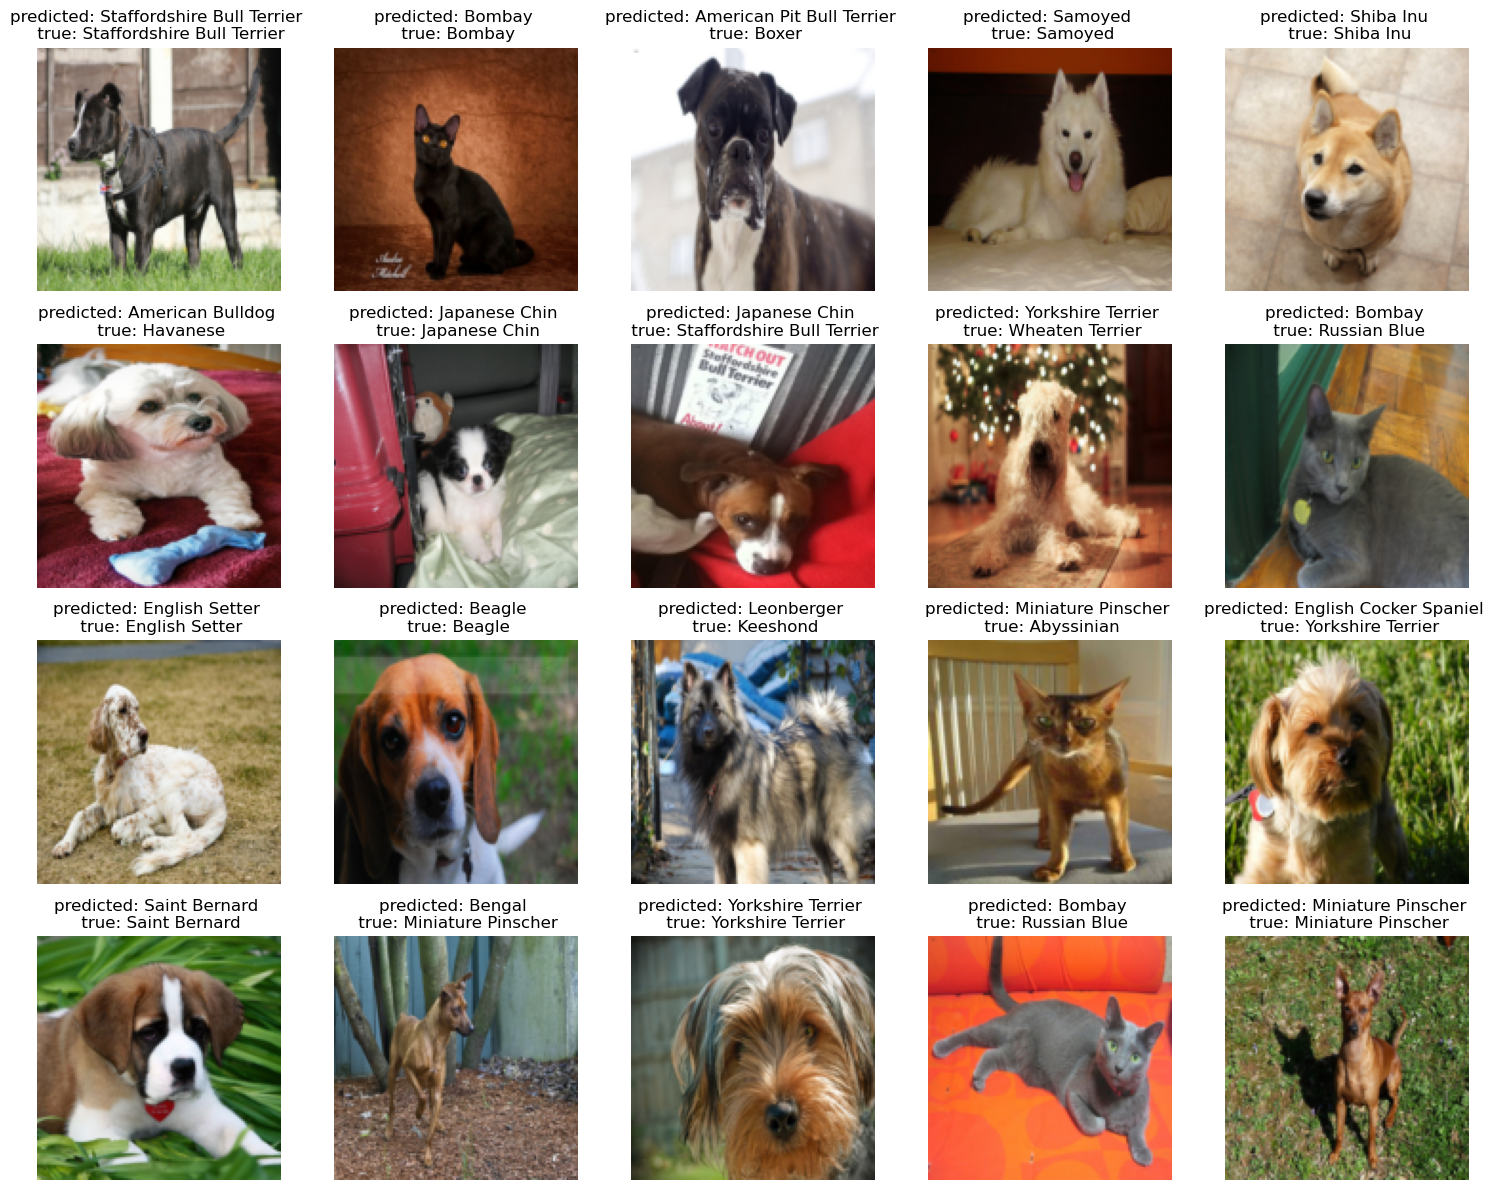

In [17]:
visualize_model(model_ft, num_images=20, batch_num=1)